# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number : 1

## Student 1 
### Name : Marios Marinos
### ID : 5353106

## Student 2
### Name : Ynze Ter Host
### ID : 4701682

In [1]:
# If this cell does not work try running `pip install nbformat`
import io
from IPython import nbformat

nb = nbformat.read("Lab2.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1055
/home/marios/.local/lib/python3.8/site-packages/IPython/nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "


## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    recall_score,
    precision_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    auc,
    mean_squared_error
)
import nltk
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import KBinsDiscretizer
from scipy.spatial import distance

plt.style.use('ggplot')

In [2]:
def plot_graph(X_train, X_test, Column : str ) -> None:
    # create a dataset that starts from future predictions to end.
    future_datest_df = df[X_train.shape[0] : ][Column].reset_index().drop(columns=' Timestamp')
    # set the indeces to train_end to final end
    future_datest_df.index = np.arange(X_train.shape[0], len(df))
    X_predicted = train(X_train, X_test, 1)
    # assign the predicted values
    future_datest_df[Column] = X_predicted
    # plot
    plt.plot(df[Column].reset_index().drop(columns=' Timestamp'), label='Original', color='green')
    plt.plot(future_datest_df, label='Prediction', color='purple')
    plt.legend()
    plt.ylabel("Signal values")
    plt.xlabel("time (s)")
    plt.title("Sensor used : {}".format(Column))

def train(X_train, X_test, order : int):
    mod = AutoReg(X_train, order, old_names=False)
    res = mod.fit()
    X_predicted = res.forecast(steps = X_test.shape[0])
    return X_predicted

def plot_many_graphs(columns_to_plot):
    for col in columns_to_plot:
        # convert the Series to a numpy array.
        column_array = df[col].to_numpy()
        # split the data
        X_train, X_test = train_test_split(column_array, test_size=0.3, random_state=42, shuffle=False)
        plot_graph(X_train, X_test, col)
        plt.show()

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [ ]:
df = pd.read_csv("SWaT_train.csv")
df.head()
# converting Timestamp to datetime so as to manipulate it easier.
df[' Timestamp'] = pd.to_datetime(df[' Timestamp'])
df.set_index([' Timestamp'], drop=True, inplace=True)
df = df.drop(columns=['Normal/Attack'])

In [ ]:
df_test = pd.read_csv("SWaT_test.csv", skipinitialspace=True).drop(columns=['Unnamed: 0', 'Timestamp'])

Rendering... Please wait


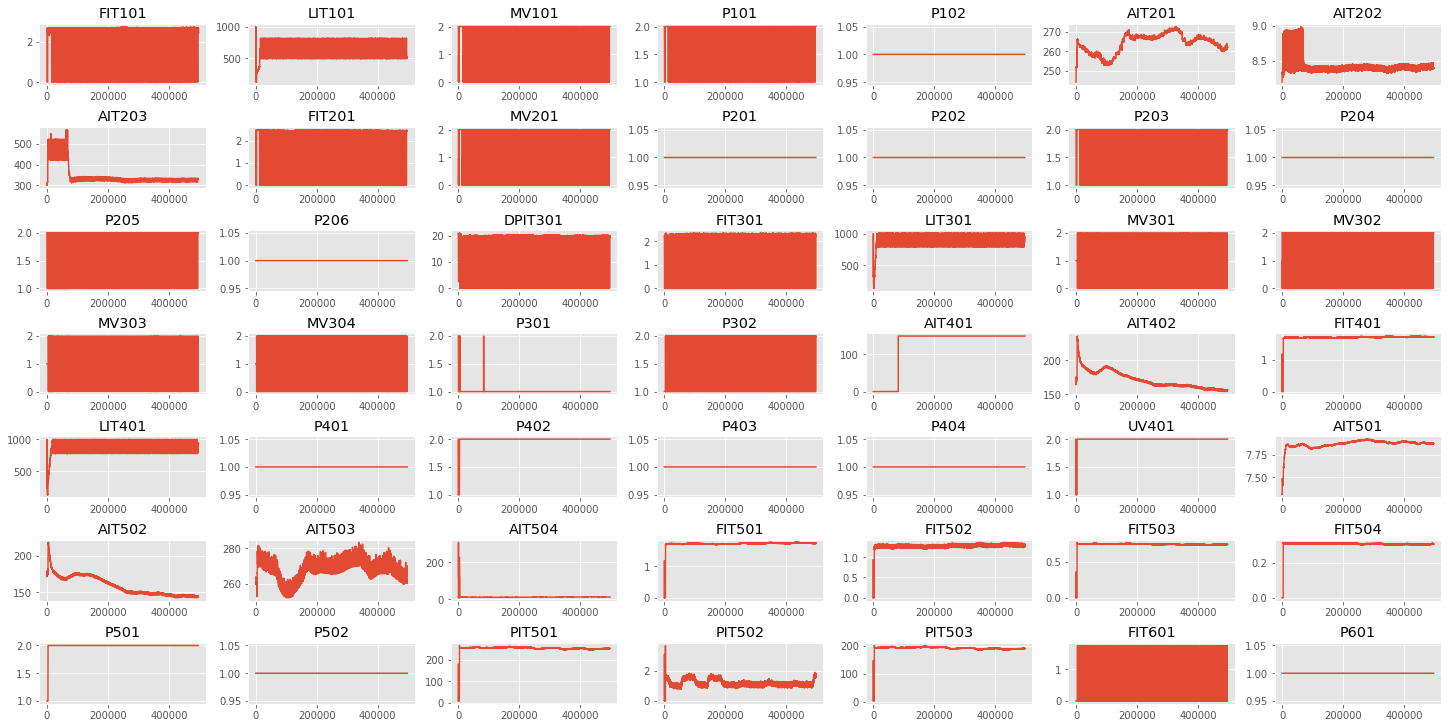

In [ ]:
fig, axs = plt.subplots(7,7, constrained_layout=True)
fig.set_size_inches((20,10))
signals = list(df.columns)
for i in range(len(signals)):
       a,b = (int(i/7), i%7)
       if (i == 49) : break
       axs[a,b].plot(range(len(df)), df[signals[i]])
       axs[a,b].set_title(signals[i])
print('Rendering... Please wait')
plt.show()

Plotting 4 different signals in more detail : PIT502, FIT101, MV101 and AIT203.

<AxesSubplot:xlabel=' Timestamp'>

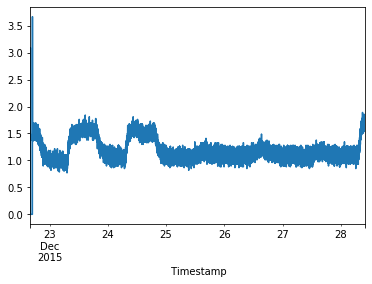

In [ ]:
df['PIT502'].plot.line() 

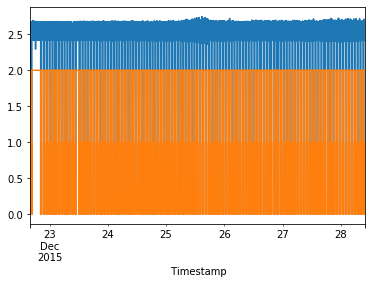

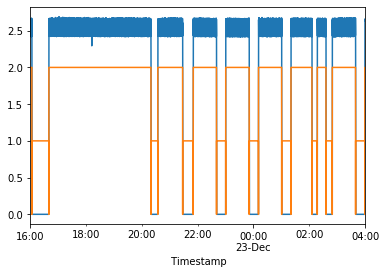

In [ ]:
df['FIT101'].plot.line()
df['MV101'].plot.line()
plt.show()
# plot again, the 2 variables but only for a half day.
# FIT101 sensor for water. 
df.loc['22/12/2015 16:00:00':'23/12/2015 04:00:00']['FIT101'].plot.line()
# MV101 actuator.
df.loc['22/12/2015 16:00:00':'23/12/2015 04:00:00']['MV101'].plot.line()
plt.show()

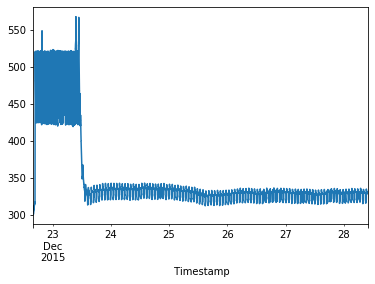

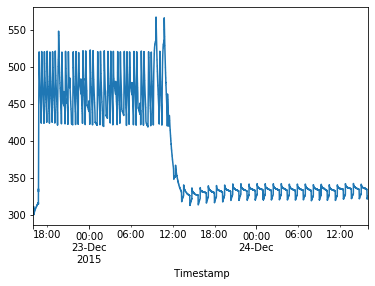

In [ ]:
# AIT203 is a sensor.
df['AIT203'].plot.line()
plt.show()
# plot AIT203 for 2 days interval.
df.loc['22/12/2015 16:00:00':'24/12/2015 16:00:00']['AIT203'].plot.line()
plt.show()

Here, we'll do the time series prediction.

In [ ]:
# predict all the columns but Normal/Attack
columns_to_predict = df.columns[df.columns != 'Normal/Attack']
# keep track of the best/worst mse and rmse
means_squared, root_squared = [], []
# columns_to_predict = ['PIT501', 'MV101']
# iterate over all columns to predict the 30% test
for col in columns_to_predict:
    # convert the Series to a numpy array.
    column_array = df[col].to_numpy()
    # split the data
    X_train, X_test = train_test_split(column_array, test_size=0.3, random_state=42, shuffle=False)
    # fit the Autoregressive model using order = 1
    X_predicted = train(X_train, X_test, 2)
    # predict mse and then rmse. append them to a list to find best/worst signals.
    mse = mean_squared_error(X_test, X_predicted)
    rmse = np.sqrt(mse)
    means_squared.append(mse)
    root_squared.append(rmse)

In [ ]:
columns_rmse = {}
for col, rmse in zip(columns_to_predict, root_squared):
    columns_rmse[col] = rmse

columns_rmse = dict(sorted(columns_rmse.items(), key=lambda item: item[1]))


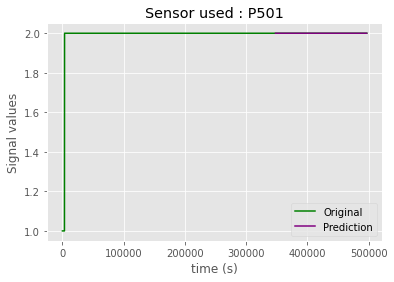

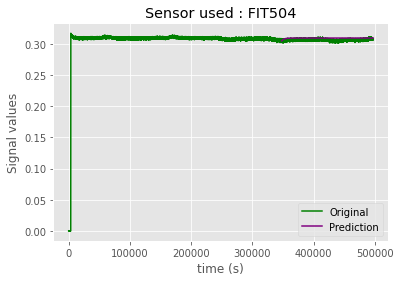

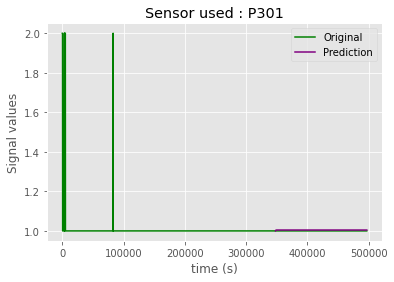

In [ ]:
keys = list(columns_rmse.keys())
best_3 = keys[:3]
worst_3 = keys [-3:]

plot_many_graphs(best_3)

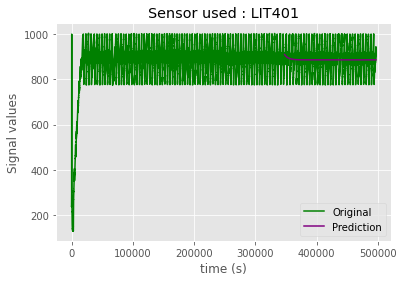

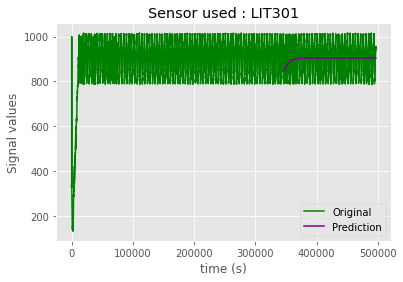

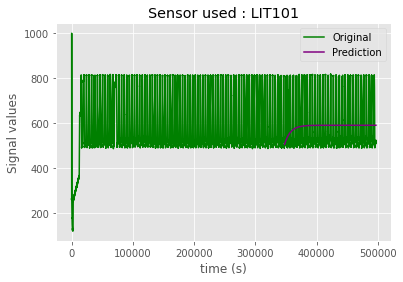

In [ ]:
plot_many_graphs(worst_3)

### 1b. Answers to the three questions

It is evident that the signals we see are of two types : Discrete and continuous. For example, FIT101 and MV101 sensors seems to be discrete (MV101 is always 0, 1 or 2) and FIT101 is either 0 or ~2.5 with fluctuations. On the other hand, AIT203 sensor is a continuous variable, that ranges from 300 to 500. This is also shown on the plotting with all signals.

We can see a clear correlation between FIT101 and MV101. Since, MV101 is always 0, 1 or 2 we think that MV101 is the actuator of FIT101. FIT101 on the other hand, is probably the sensor for the actuator MV101 if we consider the behavior of the time series (2nd graph). On the same graph, we can again see a cyclic behavior almost per hour that goes from 0 to 2.5 and stays for an hour(for FIT101). From the plot that have all the different signals, we clearly see that many signals have a cyclic behavior (e.g. FIT101, LIT101, etc.)

Series prediction : The method that we used to predict the next value for the time series was a simple AutoRegressive model and used root mean squared error to measure it's performance. As it seems, signals like P501, FIT504, P301 are easy to predict since they are linear and using the previous values gives you the next one. On the other hand, signals that have many up and downs with a huge variance (e.g. LIT401 ranges from 800 to 1000 in little time) are really hard to predict. These signals, show a cyclic behaviour as well which might be an indicator of signals that are hard to predict.





## 6.Comparision task 1

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

In [5]:
df_test = pd.read_csv("SWaT_test.csv", skipinitialspace=True).drop(columns=['Unnamed: 0', 'Timestamp'])
df = pd.read_csv("SWaT_train.csv").drop(columns=['Normal/Attack'])
# converting Timestamp to datetime so as to manipulate it easier.
df[' Timestamp'] = pd.to_datetime(df[' Timestamp'])
df.set_index([' Timestamp'], drop=True, inplace=True)
#Remove the first 12 hours because they are an empty state and we don't want to model abnormal behavior of the system.
df = df['2015-12-23 04:00:00':]
# map Normal/Attack to 0, 1 respectively.
df_test['Normal/Attack'] = df_test['Normal/Attack'].map(lambda x : 0 if x == 'Normal' else 1)
# initialize the data.
X = df.copy().to_numpy()
test_X = df_test.loc[:, df_test.columns != 'Normal/Attack'].to_numpy()
test_y = df_test['Normal/Attack'].to_numpy()

# keep metrics of the 4 methods.
results = {}

# LOF 

In [14]:
clf = LocalOutlierFactor(n_neighbors=8, algorithm='kd_tree', metric='minkowski',contamination="auto", novelty=True, n_jobs=-1)
clf.fit(X)
LOF_scores_test = clf.score_samples(test_X)

We have to hand-tune the threshold of when a data point will be considered as an outlier.

In [15]:
# -175 threshold, 75 f score 95 accuracy neighbors 8.
y_pred = np.zeros((len(df_test), 1))
threshold = -175
anomalies_indeces = np.argwhere(LOF_scores_test < threshold)
y_pred[anomalies_indeces] = 1

In [103]:
results['LOF'] = calculateCF(test_y, y_pred)

# PCA

In [100]:
# Scale data
scaler = preprocessing.StandardScaler()
train_scaled = scaler.fit_transform(X)
test_scaled = scaler.fit_transform(test_X)

results['PCA_25'] = calcAndPlotPerformance(components=25)

# ARMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               453600
Model:                 ARIMA(3, 1, 0)   Log Likelihood              560278.528
Date:                Fri, 28 May 2021   AIC                       -1120549.056
Time:                        22:05:02   BIC                       -1120504.956
Sample:                             0   HQIC                      -1120536.521
                             - 453600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1948      0.002    108.726      0.000       0.191       0.198
ar.L2          0.0598      0.002     32.047      0.000       0.056       0.063
ar.L3         -0.0025      0.001     -1.648      0.0

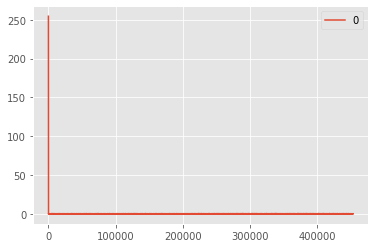

In [11]:
from statsmodels.tsa.arima.model import ARIMA
sensors = ['PIT501', 'FIT501', 'LIT301']
signal = sensors[0]

# sensors PIT 501 hyper paremeters of orders taken from individual part.
opt_p, opt_q, diff = 3,0,1
#-1125100.554
model, residuals = Model_Residuals(signal, opt_p, opt_q, differencing = diff)

In [99]:
max_threshold = defineThreshold(residuals, ratio=0.66)
predicted_values, anomalies_indeces = predict(model, signal, max_threshold)
y_pred = np.zeros((len(df_test), 1))
y_pred[anomalies_indeces] = 1  
results[f'ARMA-{signal}_AR7'] = calculateCF(test_y, y_pred)

/home/marios/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               453600
Model:                 ARIMA(4, 0, 0)   Log Likelihood             2613631.654
Date:                Fri, 28 May 2021   AIC                       -5227251.309
Time:                        21:21:21   BIC                       -5227185.159
Sample:                             0   HQIC                      -5227232.506
                             - 453600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

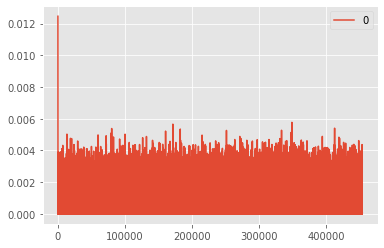

In [21]:
# sensors FIT 501 hyper paremeters of orders taken from individual part.
signal = sensors[1]
# opt param.
opt_p, opt_q, diff = 4,0,0

model, residuals = Model_Residuals(signal, opt_p, opt_q, differencing = diff)


In [97]:
# ratio 0.01 of the top residuals setting as a threshold.
max_threshold=0.0027985432466419713
predicted_values, anomalies_indeces = predict(model, signal, max_threshold)
y_pred = np.zeros((len(df_test), 1))
y_pred[anomalies_indeces] = 1  
results[f'ARMA-{signal}'] = calculateCF(test_y, y_pred)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               453600
Model:                 ARIMA(4, 0, 1)   Log Likelihood              -23805.391
Date:                Fri, 28 May 2021   AIC                          47624.782
Time:                        21:28:46   BIC                          47701.957
Sample:                             0   HQIC                         47646.718
                             - 453600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        907.6607      2.017    449.945      0.000     903.707     911.615
ar.L1          1.7395      0.002    866.016      0.000       1.736       1.743
ar.L2         -0.4686      0.003   -143.765      0.0

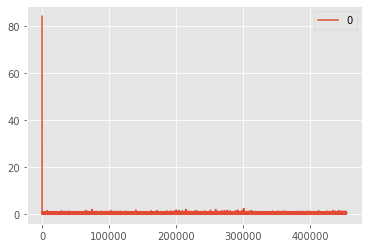

In [29]:
# sensors LIT301 hyper paremeters of orders taken from individual part.
signal = sensors[2]
# opt param.
opt_p, opt_q, diff = 4,1,0

model, residuals = Model_Residuals(signal, opt_p, opt_q, differencing = diff)


In [96]:
# ratio of 90% of the residuals are considered as attack, therefore almost all are attacks.
max_threshold = 0.03114267908074453
predicted_values, anomalies_indeces = predict(model, signal, max_threshold)
y_pred = np.zeros((len(df_test), 1))
y_pred[anomalies_indeces] = 1  
results[f'ARMA-{signal}'] = calculateCF(test_y, y_pred)

# N-GRAMS


In [18]:
def runNgram(signal, results):
    encoder = KBinsDiscretizer(n_bins=50, encode='ordinal')
    training = pd.DataFrame(train_scaled)
    training.columns = df.columns

    enc = encoder.fit_transform(pd.DataFrame(training[signal]))
    pit501grams = createNGRAMcounter(enc, 3, 100)

    pred = detectAnomalies(df_test[signal], pit501grams, 0.075)
    results[f'N_GRAM-{signal}'] = calculateCF(test_y, pred)

In [95]:
# # apply nGram on the 3 given signals.
for signal in sensors:
    runNgram(signal, results) 

# COMPARISON AND EVALUATION

In this experiment we used point-wise precision and recall to evaluate the models we used, which allows us to get a good idea of the overall performance. However, in a real scenario it may be the case that a number of false positives is actually a group of false positives that belong to the same interval that will only need to be checked once by an analyst. Conversely, it may be the case that a false negatives are grouped in the same way. This makes it hard to assess the resources that will be needed to monitor any of the implementations we have presented, specifically human analysts and unnecessary system downtime. The point-wise precision will provide an upper bound on the requirement of such resources.

In addition to that, recall and precision we included f1 scores and confusion matrices. We did this to give more insight in the balance between false positives / negatives and the total number of misclassified data points in the set as a whole. It is interesting to see that these metrics actually change with the signals as well, different models perform better on different sensors.


In [88]:
"""
Function to plot the corresponding bar charts with f1 scores, recall and precision.
"""
def plotBarCharts(keys, results):
    labels = []
    f1 = []
    recall = []
    precision = []

    for key in keys:
        labels.append(key)
        recall.append(results[key]['recall'])
        precision.append(results[key]['precision'])
        f1.append(results[key]['f1'])

    x = np.arange(len(labels))  # the label locations
    width = 0.1  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches((14,5))
    rects1 = ax.bar(x - width, f1, width, label='F1 Score')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, precision, width, label='Precision')
    ax.set_ylabel('Scores')
    ax.set_title('Scores grouped by Method')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(str('%.4f'%height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.show()


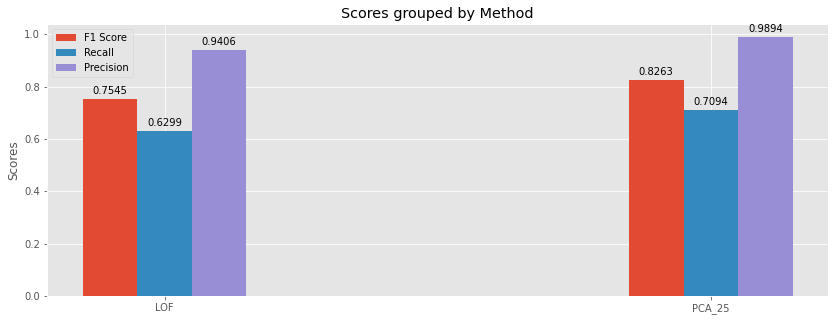

In [89]:

LOF_PCA = ['LOF', 'PCA_25']

plotBarCharts(LOF_PCA, results)

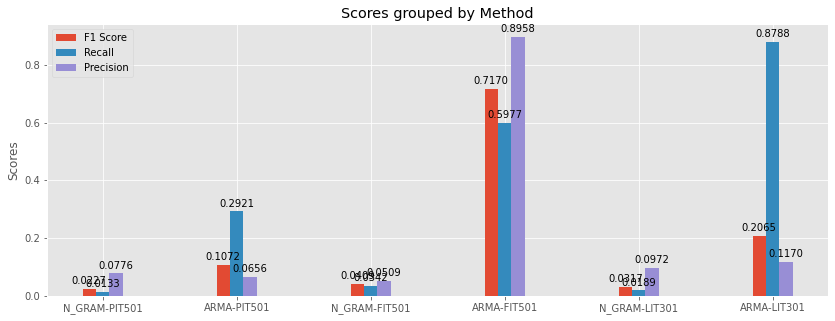

In [90]:
# arma ngrams comparisons
ARMA_NGRAMS = ['N_GRAM-PIT501', 'ARMA-PIT501', 'N_GRAM-FIT501', 'ARMA-FIT501', 'N_GRAM-LIT301', 'ARMA-LIT301']

plotBarCharts(ARMA_NGRAMS, results)

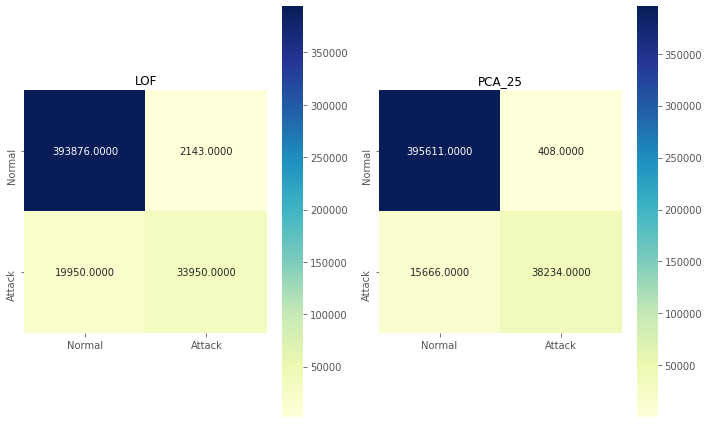

In [91]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,6)
classes=['Normal', 'Attack']

for key, ax in zip(['LOF', 'PCA_25'],axs):
    result = results[key]
    ax.set_title(key, fontsize=12)
    sns.heatmap(result['cm'], ax=ax, square=True, annot=True, fmt=".4f",cmap='YlGnBu', xticklabels=classes, yticklabels=classes)

fig.tight_layout()
plt.show()

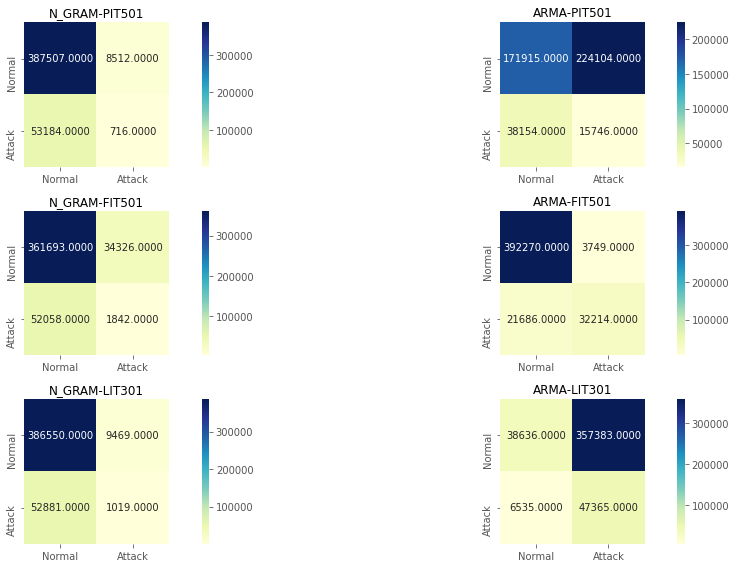

In [92]:
fig, axs = plt.subplots(3, 2)
# flatten so we can iterate over
axs = axs.flatten()
fig.set_size_inches(16,8)

for key, ax in zip(ARMA_NGRAMS, axs):
    result = results[key]
    ax.set_title(key, fontsize=12)
    sns.heatmap(result['cm'], ax=ax, square=True, annot=True, fmt=".4f",cmap='YlGnBu', xticklabels=classes, yticklabels=classes)

fig.tight_layout()
plt.show()


## Discussion of results

For the LOF and PCA models, we found their performance was significantly good. This may be due to the fact that they have more information to learn on, since they consider the entire dataset as a whole instead of just one signal. Especially PCA had a very good combination of precision and recall that achieved an F1-Score of 0.8263, after tuning the amount of components left in the representation, whereas LOF had a 0.7545. 

For ARMA and NGRAMs, the results were definitely worse. The N-gram model in particular had a dismall performance, which may be for a range of reasons like model generality or suboptimal hyperparameters (arity of n-grams, cosine similarity threshold and discretization binning). Between the signal specific models, ARMA clearly outperforms NGRAMs in our experimental setup, where we compared ARMA vs NGRAM using the same signal for 3 different signals (didn' have enough time to do it for 5 signals) but still can be tuned so as to achieve better results as NGRAM. Finally our approach for both ARMA and NGRAM, is to raise an alarm if a signal have an outlier, so we didn't follow an approach that takes into account a group of signals to raise an alarm.

All in all, we would recommend the use of a model like PCA since it performs best and is simultaneously the least computationally complex, especially in the prediction phase. If a single signal needs to be analysed we advice against using N-Gram models unless you are very confident with how the model will need to be initialized to get a good performance. Also, such a signal should ideally not be chaotic, as this causes the n-gram table to become so sparse the similarities are meaningless.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.

# METHODS FROM INDIVIDUAL PARTS

In [94]:
# METHODS FOR PLOTTING ANOMALIES AND CONFUSION MATRIX.
"""
Function that plots the predicted vs ground truth anomalies in the test data.
input : signal, and predicted anomalies indeces.
returns the ground truth beacuse we need it for the confusion matrix.
"""
def plotAnomalies(signal, anomalies_indeces):
    plt.style.use('seaborn')
    plt.figure(figsize=(10, 5))
    limit = len(df_test)
    plt.plot(df_test[signal])
    # subset_anomalies till the limit.
    subset_anomalies = anomalies_indeces[anomalies_indeces < limit]
    # x axis put the data points of the test where 
    ground_truth = df_test[signal][:limit][(df_test['Normal/Attack'] == 'Attack')]
    plt.scatter(ground_truth.index, ground_truth.values , marker="^", alpha=0.5, color='green', label="ground truth anomaly")
    plt.scatter(subset_anomalies, predicted_values.values[subset_anomalies], alpha=0.025, color='aqua', marker="x", label="predicted anomaly")
    plt.legend()
    plt.show()
    return ground_truth, subset_anomalies

"""
Function that returns all the statistics needed (confusion matrix, f1, recall, prec, etc.)
input : ground truth anomalies, predictions anomalies.
"""
def calculateCF(ground_truth, predictions):
    results = {}
    results['cm'] = confusion_matrix(ground_truth, predictions)
    results["tn"], results['fp'], results['fn'], results['tp'] = confusion_matrix(ground_truth, predictions).ravel()
    results['precision'] = precision_score(ground_truth, predictions)
    results['recall'] = recall_score(ground_truth, predictions)
    results['f1'] = f1_score(ground_truth, predictions)
    results['accuracy'] = accuracy_score(ground_truth, predictions)
    fpr_model, tpr_model, _ = roc_curve(ground_truth, predictions)
    results["false_pos_rate"] = fpr_model
    results["true_pos_rate"] = tpr_model
    return results

In [8]:
# METHOD FOR PCA
def calcAndPlotPerformance(components):
    # Fit the model with investigated amount of principal components
    model = PCA(n_components=components)
    model.fit(train_scaled)

    # Calculate the explainability of the test data
    avg = model.score(test_scaled)
    sample_scores = model.score_samples(test_scaled)

    # Make a groundtruth - prediction dataframe
    pred = pd.DataFrame(df_test['Normal/Attack'])
    # categories = {'Normal': 0, 'Attack' : 1}
    # pred['Normal/Attack'] = pred['Normal/Attack'].map(categories)
    pred['prediction'] = sample_scores
    pred['prediction'].values[pred['prediction'].values < 1.5 * avg] = 1
    pred['prediction'].values[pred['prediction'].values != 1] = 0

    # Get all the metrics and the corresponding confusion matrix.
    return calculateCF(pred['Normal/Attack'], pred['prediction'])

In [9]:
# METHODS FOR N-GRAMS
def createNGRAMcounter(encoding, n, amountOfWindows):
    length = int(len(encoding) / amountOfWindows)
    counts = pd.DataFrame()
    signal = pd.DataFrame(encoding)
    signal.columns = ['column']
    for i in range(1, 100):
        temp = pd.Series(nltk.ngrams(signal['column'][(i-1)*length:i*length], n), name=i).value_counts()
        counts = pd.DataFrame.join(counts, temp, how='outer')

    return counts.fillna(0).T

def dist(x0, x1, x2, x3, grams):
    tuple1 = (float(str(x0)[1:-1] + "0"), float(str(x1)[1:-1] + "0"), float(str(x2)[1:-1] + "0"))
    tuple2 = (float(str(x1)[1:-1] + "0"), float(str(x2)[1:-1] + "0"), float(str(x3)[1:-1] + "0"))

    if tuple1 in grams.columns:
        col1 = grams[tuple1]
    else:
        col1 = grams["def"]

    if tuple2 in grams.columns:
        col2 = grams[tuple2]
    else:
        col2 = grams["def"]

    return distance.cosine(col1, col2)

def detectAnomalies(signal, grams, threshold):
    anomalies = np.zeros(len(signal))

    # add column for unseen combinations
    grams['def'] = 0
    
    # discretize signal
    encoder = KBinsDiscretizer(n_bins=10, encode='ordinal')
    signal = encoder.fit_transform(pd.DataFrame(signal))

    print("Busy, please wait...")
    # loop through signal to find anomalies
    for i in range(0, len(signal) - 3):
        if dist(signal[i], signal[i + 1], signal[i + 2], signal[i + 3], grams) > threshold:
            anomalies[i+3] = 1
        else:
            anomalies[i+3] = 0

    return anomalies


In [10]:
# METHODS FOR ARMA
"""
 Function that re-train with the optimal values and print the residuals plot, density plot of residuals and statstics.
 input : signal, optimal order AR, MA and differencinf if needed.
"""
def Model_Residuals(signal, opt_p, opt_q, differencing):
    # Re run the best obtained model to keep track of the residuals .
    model = ARIMA(df[signal].values, order=(opt_p, differencing, opt_q)).fit()
    # summary of fit model
    print(model.summary())
    # line plot of residuals
    residuals = pd.DataFrame(model.resid)
    # change the residuals to the absolute value because the sign doesn't matter.
    residuals = residuals.abs()
    residuals.plot()
    plt.show()
    return model, residuals

"""
input : model already trained in the training data, signal : signal to predict.
return : return the predicted model values, anomalies_indeces : return the indeces of the anomalies found.
"""
def predict(model, signal : str, threshold):
    # predictions numbers
    model_test = model.apply(df_test[signal])
    # take the residuals abs
    res_test = model_test.resid.abs()
    predicted_values = model_test.predict(0, len(df_test) - 1)
    # True if it's an outlier
    anomalies_prediction = res_test.abs().values > threshold
    # where the anomalies occur.
    anomalies_indeces = np.argwhere(anomalies_prediction==True)
    return predicted_values, anomalies_indeces

"""
To make the prediction we have to come up with a threshold that we deicde based on the residuals. In general, we know that
the higher the residual is, the more "anomaly" we can say it is.
pick a ratio, say 5% for now and the threshold will be the lowest one.
"""
def defineThreshold(residuals, ratio):
    residuals_sorted = residuals.sort_values(by=0, ascending=False).reset_index(drop=True)
    # take the last value as threshold to consider it an outlier.
    threshold = float(residuals_sorted[:int(len(residuals_sorted) * ratio)].iloc[-1])
    return threshold


